# Sentiment Analysis using a RoBERTa model

In [1]:
# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import sys

# Packages for file opening
import tkinter as tk
from tkinter import filedialog

plt.style.use('ggplot')
import seaborn as sns
import nltk

# Packages for RoBERTa model
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [2]:
# Create Tkinter root window
root = tk.Tk()
root.withdraw()

# Prompt the user to select an Excel file using a file dialog
file_path = filedialog.askopenfilename(filetypes=[("Excel Files", "*.xls *.xlsx")])

In [3]:
# Close program if no file opened
if not file_path:
    print("No file selected. Ending program now.")
    sys.exit()

# Read selected excel file using pandas
data = pd.read_excel(file_path)
print(data['Score'])

0      5
1      1
2      4
3      2
4      5
      ..
993    5
994    5
995    5
996    1
997    2
Name: Score, Length: 998, dtype: int64


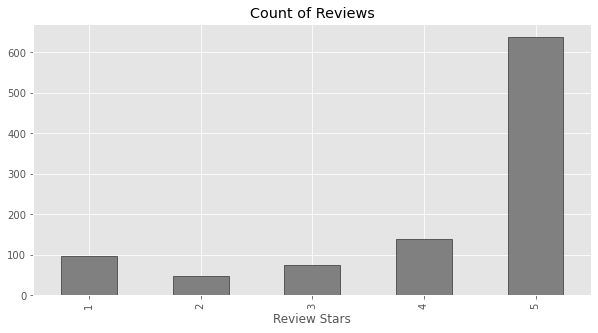

In [4]:
# Create and show histogram showing counts of review stars
score_plot = data['Score'].value_counts().sort_index().plot(kind='bar',
                                                            title='Count of Reviews', figsize=(10, 5),
                                                            color='gray', edgecolor='black')
score_plot.set_xlabel('Review Stars')
plt.show()

In [5]:
# NLTK initialization
example = data['Text'][26]
tokens = nltk.word_tokenize(example)
tagged = nltk.pos_tag(tokens)
chunked = nltk.chunk.ne_chunk(tagged)
print(example)

The candy is just red , No flavor . Just  plan and chewy .  I would never buy them again


In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

In [7]:
sia = SentimentIntensityAnalyzer()
results = {}

In [8]:
#RoBERTa (Robustly Optimized Bidirectional Encoder Representations from Transformers) Model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

encoded_text = tokenizer(example, return_tensors='pt', max_length=512, truncation=True)
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    "roberta_neg" : scores[0],
    "roberta_neu" : scores[1],
    "roberta_pos" : scores[2]
}

In [9]:
#Set up function to use RoBERTa model on data
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt', max_length=512, truncation=True)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        "roberta_neg": scores[0],
        "roberta_neu": scores[1],
        "roberta_pos": scores[2]
    }
    return scores_dict

In [10]:
#Function to convert RoBERTa model results into easy to read column
def get_sentiment(row):
    if row['roberta_neg'] > row['roberta_pos'] and row['roberta_neg'] > row['roberta_neu']:
        return 'Negative'
    if row['roberta_pos'] > row['roberta_neg'] and row['roberta_pos'] > row['roberta_neu']:
        return 'Positive'
    if row['roberta_neu'] > row['roberta_pos'] and row['roberta_neu'] > row['roberta_neg']:
        return 'Neutral'
    else:
        return 'Uh oh'

In [11]:
#Run RoBERTa model on data
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['Text']
        myid = row['Id']
        # Converts non string variables to strings
        if type(text) is not str:
            text = str(text)
        roberta_results = polarity_scores_roberta(text)

        results[myid] = roberta_results
    except RuntimeError:
        print(f'Broke for id {myid}')

100%|██████████| 998/998 [01:20<00:00, 12.37it/s]


In [12]:
#Apply results to a pandas dataframe and create the new user friendly column
roberta = pd.DataFrame(results).T
roberta = roberta.reset_index().rename(columns={'index': 'Id'})
roberta = roberta.merge(data, how='left')
roberta['sentiment'] = roberta.apply(get_sentiment, axis=1)

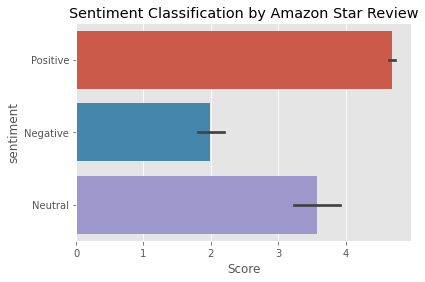

In [13]:
# Check compound score from roberta model against star score review
tester_plot = sns.barplot(data=roberta, x='Score', y='sentiment')
tester_plot.set_title('Sentiment Classification by Amazon Star Review')
plt.show()

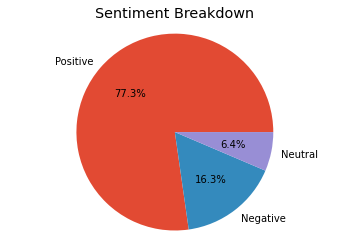

In [14]:
# Pie chart showing sentiment
sentiment_counts = roberta['sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Sentiment Breakdown')
plt.show()

In [15]:
# Choose file name and location
export_path = filedialog.asksaveasfilename(defaultextension='.xlsx', filetypes=[('Excel Files', '*.xlsx')])

In [16]:
print(roberta.head(5))

   Id  roberta_neg  roberta_neu  roberta_pos   ProductId          UserId  \
0   1     0.009624     0.049980     0.940395  B001E4KFG0  A3SGXH7AUHU8GW   
1   2     0.508986     0.452414     0.038600  B00813GRG4  A1D87F6ZCVE5NK   
2   3     0.003229     0.098067     0.898704  B000LQOCH0   ABXLMWJIXXAIN   
3   4     0.002295     0.090219     0.907486  B000UA0QIQ  A395BORC6FGVXV   
4   5     0.001635     0.010302     0.988063  B006K2ZZ7K  A1UQRSCLF8GW1T   

                       ProfileName HelpfulnessNumerator  \
0                       delmartian                    1   
1                           dll pa                    0   
2  Natalia Corres "Natalia Corres"                    1   
3                             Karl                    3   
4    Michael D. Bigham "M. Wassir"                    0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000  

In [17]:
# End program if no export path chosen
if not export_path:
    print("No file saved. Program will exit.")
    sys.exit()

In [18]:
# Export to Excel
roberta.to_excel(export_path, index=False)